<a href="https://colab.research.google.com/github/123ranika/jsfinal/blob/main/sagorsarker_bangla_bert_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Performing checks for the resources available

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [ ]:
!pip install transformers

## Importing necessary packages

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Loading training data

In [ ]:
import pandas as pd

# Attempt to read the file with ISO-8859-1 encoding
data = pd.read_csv('/content/DataSetCollection.csv')


In [ ]:
# Add an ID column starting from 1
data['PID'] = range(1, len(data) + 1)

In [ ]:
data.head()

,PID,text,labels,source,page/channel,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,1,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
1,2,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
2,3,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
3,4,এটা কি আমাদের ধর্মজাল,Religious_Hatred,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
4,5,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd

# Function to rename a single column
def change_column_name(df, old_name, new_name):
    df = df.rename(columns={old_name: new_name})
    return df

# Assuming df is your DataFrame
data = change_column_name(data, old_name="Label", new_name="labels")
data = change_column_name(data, old_name="Comments", new_name="text")
data.head() # Display the first few rows of the DataFrame
#text


# Move the ID column to the first position
cols = ['PID'] + [col for col in data.columns if col != 'PID']
data = data[cols]

data.head()

,PID,text,labels,source,page/channel,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,1,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
1,2,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
2,3,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
3,4,এটা কি আমাদের ধর্মজাল,Religious_Hatred,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
4,5,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN


In [ ]:


# Keep only the specified three columns
# Replace 'column1', 'column2', 'column3' with your actual column names
data = data[['PID', 'text', 'labels']]

# Report the number of sentences
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data
print(data.sample(10))


Number of training sentences: 9,250

       PID                                               text  \
586    587                          হুংকার গারে গুঁজে দিয়েছে   
2473  2474                                  বাহ চুদির ভাই বাহ   
7145  7146    বউয়ের শাড়ী খুলেও যেন খুলছে না...কী একটা অবস্থা    
3542  3543                              আপা আমারে দেখতে পারেন   
3063  3064                         স্যার কমেন্টের সবই রাজাকার   
1145  1146                মেয়েটার এক্সপ্রেশন বলে দেয় ও আনাড়ি,   
6144  6145                       কাওয়ালির কাছে তোমরা ফ্লপ...   
8840  8841                           এই খানকিরে দেখলে বমি আসে   
620    621  ফারিন অনেক মজার কিন্তু তার নাটক দেখলে বুঝা যায় না   
6065  6066                       প্রশাসন কি দায়িত্ব পালন করছে   

                     labels  
586                 Sarcasm  
2473          Cyberbullying  
7145  Gender_Discrimination  
3542                Sarcasm  
3063              Political  
1145                Sarcasm  
6144                Sarcasm  
8840  G

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# # Read the file with ISO-8859-1 encoding
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Nazir Sir/spam - spam.csv', encoding='ISO-8859-1')

# First, split the data into training and temp (test + validation)
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42)

# Then split temp_data into test and validation sets (50% each of temp_data, so 15% of the total for each)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
train_df

,PID,text,labels
8329,8330,আবার কবে শুরু হবে কুকুরমালাও খানকি মালা,Cyberbullying
2301,2302,মুক্তিযুদ্ধা ছাড়া বাকিরা রাজাকার,Political
7672,7673,"তোর ধর্মে কিছু নেই, সব বাজে।",Religious_Hatred
1701,1702,মিরাজের ভিটামিনের পাওয়ার,Sarcasm
2518,2519,শকুনের দৃষ্টি পড়েছে মুক্তি যোদ্ধা কোটার উপর,Political
...,...,...,...
5734,5735,কুত্তা লীগ,Cyberbullying
5191,5192,এখন নাচতে শুরু করেছে পরে বাঁচতে শুরু করবে,Sarcasm
5390,5391,পাগোল যদি মাঠে থাকে তাহলে বিবাহ হবেনানে,Sarcasm
860,861,অতি টিপার ফল,Cyberbullying


In [ ]:
test_df

,PID,text,labels
7345,7346,গণ বিবাহতে আপা ও ছিলো। আপারে দেখতে অনেক কিউট ল...,Gender_Discrimination
8290,8291,পোলার গুষ্টিরে কুমিল্লার মানুষে করছে,Racism
1126,1127,তোর বাপের সাথে সংসার থাকলে ভেঙ্গে তো যাবেই!,Cyberbullying
2275,2276,ঘুমাইলাম কাম শেষ হইলে আমারে ডাক দিস,Sarcasm
9215,9216,জয় বাংলা তোর নানীর পুটকি সামলা,Gender_Discrimination
...,...,...,...
7695,7696,তুই একটা হারামির বাচ্চা।,Cyberbullying
4993,4994,বিবিসি তখন ধর্মহীনতার প্রতি উৎসাহিত করছে,Cyberbullying
9248,9249,মিম এখন টয়লেটেমিম এখন টয়লেটে,Gender_Discrimination
2698,2699,সরকার কেগদি থেকে রাস্তায় নামার আন্দোলন,Political


In [ ]:
val_df

,PID,text,labels
1038,1039,আমাগোরে গার্ড স্যারেই কাপায় দিছে,Sarcasm
7831,7832,তোর জাতি সবসময় সমস্যার সৃষ্টি করে।,Racism
5563,5564,যু্দ্ধ করবো ভারতের বিরুদ্ধে,Political
1595,1596,এ হুজুরের পামু কোন জায়গায় খানকির পোলার কানসা...,Cyberbullying
2906,2907,এতেরে ডিম থেরাপি দিতে হবে,Sarcasm
...,...,...,...
7078,7079,ভারতীয় এনিমেল... \nপাপা পাপা পাপা পাপা পাপা পা...,Gender_Discrimination
8782,8783,মাগি তুরে কুত্তা দিয়া চুদান উচিত,Cyberbullying
4680,4681,ফতোয়া দেওয়া স্বৈরাচারের মতোই তো বর্তমানদের আচরণ,Political
2680,2681,আল্লাহ পাক তাহাকে জান্নাতুল টুঙ্গিপাড়া দান করুন,Sarcasm


In [ ]:
train_df['labels'].value_counts()

,count
labels,
Cyberbullying,2002
Sarcasm,1888
Political,971
Religious_Hatred,882
Gender_Discrimination,801
Racism,792


In [ ]:

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [ ]:
train_df['labels'].value_counts()

,count
labels,
0,2002
5,1888
2,971
4,882
1,801
3,792
6,64


### Loading `train_sentences` and `train_labels`

In [ ]:
# Get the lists of sentences and their labels.
train_sentences = train_df['text'].values
train_labels = train_df['labels'].values

## Saving Class Names

In [ ]:
data.labels.unique()

array(['Cyberbullying', 'Religious_Hatred', 'Gender_Discrimination',
       'Sarcasm', 'Political', 'Racism', nan], dtype=object)

In [ ]:
class_names = [
            'Cyberbullying', 'Religious_Hatred', 'Gender_Discrimination',
       'Sarcasm', 'Political', 'Racism'
]

## Loading the validation data

In [ ]:
val_df['labels'] = le.transform(val_df['labels'])

In [ ]:

val_df['labels'].value_counts()

,count
labels,
0,228
5,211
2,153
4,116
1,111
3,99
6,7


### Loading `val_sentences` and `val_labels`

In [ ]:
# Get the lists of sentences and their labels.
val_sentences = val_df['text'].values
val_labels = val_df['labels'].values

In [ ]:
val_labels

array([5, 3, 2, 0, 5, 4, 3, 0, 1, 0, 4, 4, 3, 4, 5, 3, 5, 1, 0, 1, 3, 0,
       3, 1, 0, 0, 0, 5, 2, 1, 4, 1, 1, 4, 5, 2, 0, 0, 0, 5, 2, 5, 5, 1,
       5, 5, 3, 0, 5, 0, 4, 3, 1, 0, 3, 0, 5, 0, 5, 2, 5, 0, 3, 2, 3, 5,
       5, 2, 2, 4, 5, 5, 5, 5, 3, 1, 5, 4, 4, 5, 0, 0, 4, 1, 3, 4, 2, 2,
       0, 2, 4, 0, 5, 2, 0, 3, 5, 4, 5, 2, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0,
       2, 4, 2, 5, 4, 3, 0, 4, 3, 2, 2, 4, 5, 5, 0, 0, 0, 5, 2, 4, 1, 2,
       1, 5, 5, 2, 0, 4, 5, 0, 2, 0, 3, 4, 0, 1, 5, 0, 5, 0, 0, 0, 5, 1,
       5, 1, 5, 5, 0, 2, 3, 0, 0, 2, 0, 1, 0, 0, 1, 4, 5, 5, 2, 2, 0, 0,
       3, 1, 1, 4, 0, 6, 1, 5, 5, 2, 2, 4, 0, 5, 0, 2, 5, 1, 0, 0, 0, 2,
       3, 2, 5, 0, 0, 5, 3, 1, 2, 5, 5, 2, 5, 1, 5, 5, 0, 5, 0, 0, 5, 0,
       5, 2, 3, 4, 0, 1, 1, 0, 2, 1, 0, 4, 0, 0, 0, 2, 2, 1, 1, 1, 2, 0,
       3, 5, 0, 0, 5, 1, 5, 2, 1, 2, 2, 2, 0, 2, 3, 3, 3, 2, 0, 2, 3, 1,
       3, 0, 0, 1, 5, 5, 3, 5, 3, 4, 0, 0, 5, 0, 5, 4, 2, 1, 0, 0, 0, 3,
       5, 2, 1, 4, 2, 2, 2, 3, 5, 0, 5, 5, 1, 4, 3,

## Helper Functions

#### 1) Update Interval Function

In [ ]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [ ]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


In [ ]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


#### 4) Function for calculating accuracy per class

In [ ]:
def accuracy_per_class(preds, labels , label_dict):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 5) Function for plotting training history

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [ ]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [ ]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [ ]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [ ]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [ ]:
model_name = 'sagorsarker/bangla-bert-base'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading sagorsarker/bangla-bert-base tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))

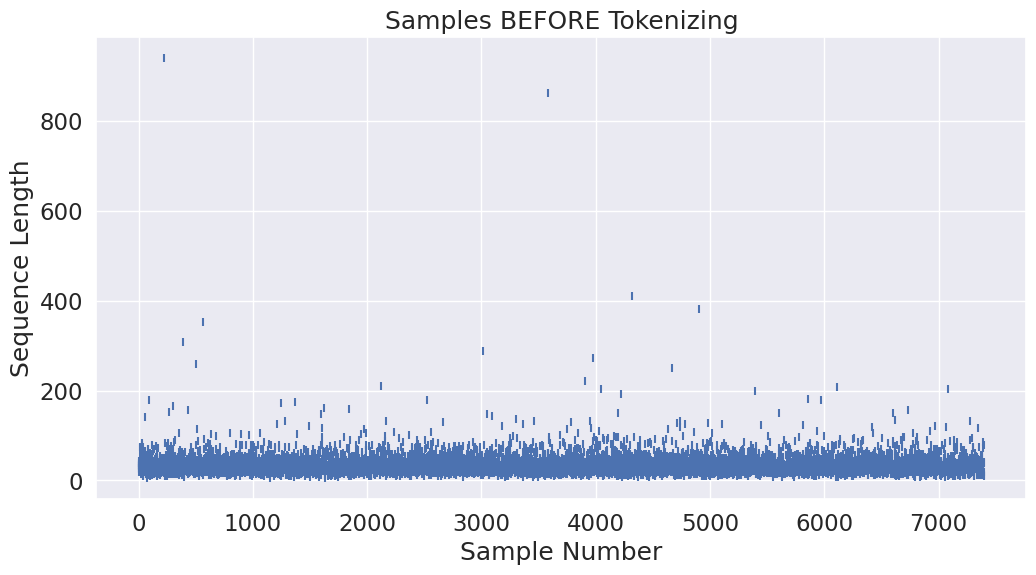

In [ ]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [ ]:
max_input_length = 300

In [ ]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_input_length,
                                 truncation=True,
                                 padding=False)

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 7,400 training samples...
  Tokenized 0 samples.
  Tokenized 700 samples.
  Tokenized 1,400 samples.
  Tokenized 2,100 samples.
  Tokenized 2,800 samples.
  Tokenized 3,500 samples.
  Tokenized 4,200 samples.
  Tokenized 4,900 samples.
  Tokenized 5,600 samples.
  Tokenized 6,300 samples.
  Tokenized 7,000 samples.
DONE.
     7,400 samples


In [ ]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

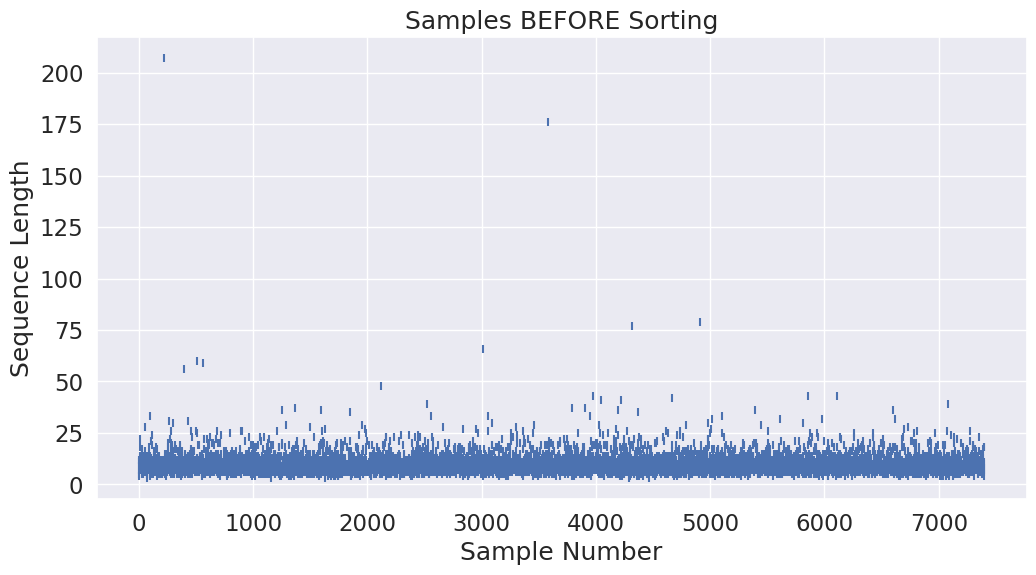

In [ ]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [ ]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [ ]:
train_samples[0:5]

[([101, 46214, 102], 0),
 ([101, 12336, 102], 0),
 ([101, 100, 102], 0),
 ([101, 18168, 102], 1),
 ([101, 13999, 102], 5)]

In [ ]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 207


In [ ]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

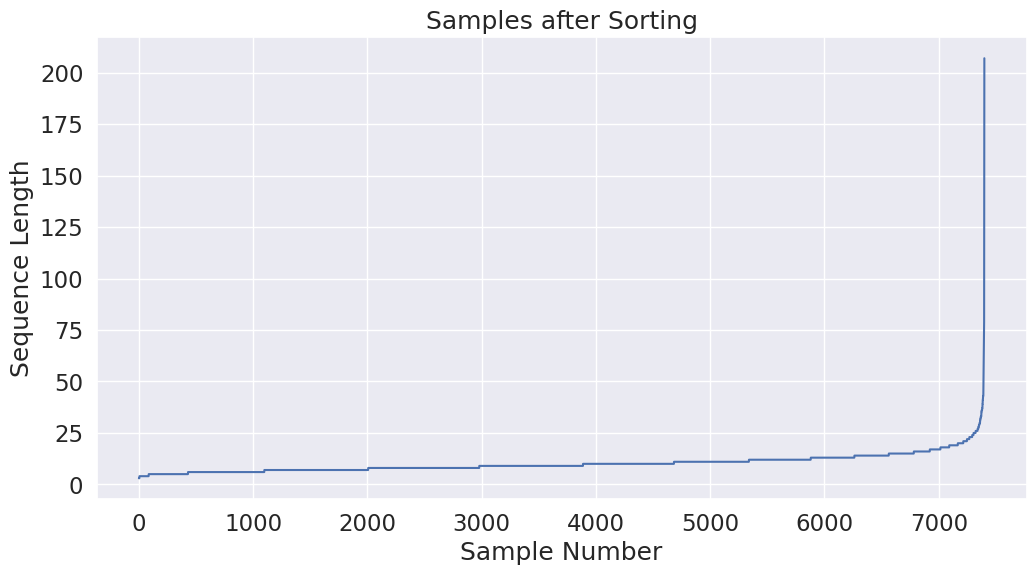

In [ ]:


plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [ ]:
train_samples[0]

([101, 46214, 102], 0)

In [ ]:
batch_size = 16

In [ ]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.
  Selected 300 batches.
  Selected 400 batches.

  DONE - 463 batches.


In [ ]:
print(batch_ordered_sentences[0])

[[101, 35914, 2040, 2137, 2877, 6557, 2094, 2534, 12768, 3701, 102], [101, 100, 2139, 100, 2078, 8625, 100, 5025, 2076, 5843, 102], [101, 8415, 24182, 8499, 30341, 2285, 35759, 2756, 2039, 3882, 102], [101, 2103, 2178, 2045, 3020, 14380, 100, 1045, 1045, 1045, 102], [101, 21597, 2094, 2101, 100, 3916, 37535, 1011, 1011, 1011, 102], [101, 7198, 16416, 2094, 51370, 39721, 15889, 20830, 3244, 7083, 102], [101, 15301, 2178, 100, 33067, 2070, 2127, 2178, 100, 33067, 102], [101, 8239, 12910, 7761, 2044, 2080, 2145, 2169, 20209, 3637, 102], [101, 27864, 2070, 6691, 57433, 33802, 2066, 100, 100, 1014, 102], [101, 10923, 9022, 1011, 42667, 2055, 3590, 4761, 1011, 10911, 102], [101, 100, 19571, 100, 13517, 46069, 2120, 2286, 12309, 2124, 102], [101, 2873, 9684, 6653, 1104, 7464, 17764, 12896, 100, 1014, 102], [101, 9338, 67043, 2134, 2052, 4972, 2570, 3609, 27248, 3187, 102], [101, 31504, 2395, 55442, 2454, 14940, 23916, 100, 2149, 2857, 102], [101, 18891, 9209, 53709, 16662, 10209, 5374, 66416,

In [ ]:
batch_ordered_labels[0]

[0, 3, 4, 0, 5, 5, 2, 5, 4, 5, 4, 4, 5, 1, 0, 4]

### Padding

In [ ]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [ ]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 2,220,000
  Smart Batching: 79,544  (96.4% less)


## Load the model configuration from the transformers library using AutoConfig

In [ ]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.bert.configuration_bert.BertConfig'> 



In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## Load the model from the transformers library using AutoModel

In [ ]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))



Model type: <class 'transformers.models.bert.modeling_bert.BertModel'>


In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model

In [ ]:

# class BERT_Model(nn.Module):
#     ## defining the constructor for the class
#     def __init__(self, bert,num_labels):
#       ## calling the super class constructor
#       super(BERT_Model, self).__init__()
#       ## adding the bert layer to the model
#       self.bert = bert
#       # relu activation function
#       self.relu =  nn.ReLU()
#       # adding a dense layer to our custom model
#       self.fc1 = nn.Linear(768,512)
#       # adding another dense layer to our custom model ,i.e., the Output layer
#       self.fc2 = nn.Linear(512,num_labels)
#       # adding a softmax  activation function for our custom model's output layer
#       self.softmax = nn.LogSoftmax(dim=1)

#     #defining the forward pass
#     def forward(self, input_id, mask):
#       #pass the inputs to the model
#       outputs = self.bert(input_id,mask)

#       last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
#       pooler_output = outputs.pooler_output               ## pooler output from the model
#       ## adding a fully connected layer to the BERT model
#       x = self.fc1(pooler_output)
#       ## applying relu activation function
#       x = self.relu(x)
#       # the final output layer
#       x = self.fc2(x)
#       # apply softmax activation to our output layer
#       x = self.softmax(x)

#       return x

In [ ]:


# print('\nLoading model ...')
# # pass the pre-trained BERT to our define architecture
# model = BERT_Model(bert,num_labels=3)

# model.cuda()

## Custom Loss function

In [ ]:
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights)


## Loading Optimizer

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loading lr scheduler

In [ ]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# import numpy as np
# from sklearn.preprocessing import LabelEncoder

# # Check if all validation labels are present in the training labels
# missing_labels = set(val_labels) - set(train_labels)

# if missing_labels:
#     print(f"Warning: The following labels in validation data were not seen in the training data: {missing_labels}")
#     # Optionally, you could handle missing labels here, either by filtering or adding them to the encoder.
# else:
#     # Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
#     val_labels_encoded = label_encoder.transform(val_labels)

# # Now continue with the rest of the training as planned.


## Training Loop

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load and prepare the dataset
data_path = '/content/DataSetCollection.csv'
df = pd.read_csv(data_path)

# Define column names for text and labels (update as necessary)
sentence_column = 'text'    # Replace if column name differs
label_column = 'labels'   # Replace if column name differs

# Extract text and labels
texts = df[sentence_column].astype(str).tolist()
labels = df[label_column].tolist()

# Split data into training and validation sets (80/20 split)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Vectorize text data using TF-IDF with reduced features for faster computation
vectorizer = TfidfVectorizer(max_features=1000)  # Lowered max_features for speed
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=100, solver='liblinear')  # Limited iterations, faster solver
model.fit(X_train, train_labels)

# Evaluate the model on the validation set
val_predictions = model.predict(X_val)
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {accuracy:.2f}")

# Print detailed evaluation metrics
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(val_labels, val_predictions))


'''import time
import torch
from sklearn.preprocessing import LabelEncoder


# Assuming your labels are strings like 'ham' and 'spam', we first fit the LabelEncoder on the training labels
label_encoder = LabelEncoder()

# Convert training labels to numeric values
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
val_labels_encoded = label_encoder.transform(val_labels)

# Now, we can proceed with the rest of the code for training and validation.

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = {
    'epoch': [],
    'train_loss': [],
    'Training Time': [],
    'val_loss': [],
    'Validation Time': [],
    'train_acc': [],
    'val_acc': []
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')

    if epoch_i > 0:
        # Re-shuffle the dataset into new batches
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels_encoded, batch_size, tokenizer, max_input_length)

    print(f'Training on {len(py_inputs):,} batches...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step in range(0, len(py_inputs)):

        if step % update_interval == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            remaining_sec = (time.time() - t0) / step * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)
            print(f'  Batch {step:>7,} of {len(py_inputs):>7,}. Elapsed: {elapsed}. Remaining: {remaining}')

        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        model.zero_grad()
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(py_inputs)
    training_accuracy = check_accuracy(predictions, true_labels)
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training Accuracy: {training_accuracy:.2f}")
    print(f"  Training epoch took: {training_time}")

    # Validation
    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels_encoded, batch_size, tokenizer, max_input_length)
    val_loss, val_accuracy, validation_time = eval_model(model, py_inputs, py_attn_masks, py_labels)

    print("")
    print(f"  Average validation loss: {val_loss:.2f}")
    print(f"  Validation Accuracy: {val_accuracy:.2f}")
    print(f"  Validation epoch took: {validation_time}")

    # Record all statistics from this epoch.
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print(f"Training complete! Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")'''


Validation Accuracy: 0.44

Classification Report:
                       precision    recall  f1-score   support

        Cyberbullying       0.39      0.54      0.46       503
Gender_Discrimination       0.50      0.28      0.36       199
            Political       0.58      0.37      0.45       276
               Racism       0.50      0.25      0.33       208
     Religious_Hatred       0.73      0.54      0.62       224
              Sarcasm       0.36      0.52      0.42       422
                  nan       0.00      0.00      0.00        18

             accuracy                           0.44      1850
            macro avg       0.44      0.35      0.38      1850
         weighted avg       0.47      0.44      0.44      1850


Confusion Matrix:
[[271  20  27  12   9 164   0]
 [ 75  55   7   9   4  49   0]
 [ 72   5 101  14  12  72   0]
 [ 59  13  12  51   5  68   0]
 [ 47   5  11   7 120  34   0]
 [154  12  15   9  14 218   0]
 [  9   0   0   1   0   8   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'import time\nimport torch\nfrom sklearn.preprocessing import LabelEncoder\n\n\n# Assuming your labels are strings like \'ham\' and \'spam\', we first fit the LabelEncoder on the training labels\nlabel_encoder = LabelEncoder()\n\n# Convert training labels to numeric values\ntrain_labels_encoded = label_encoder.fit_transform(train_labels)\n\n# Convert validation labels using the same LabelEncoder to ensure the mapping is consistent\nval_labels_encoded = label_encoder.transform(val_labels)\n\n# Now, we can proceed with the rest of the code for training and validation.\n\n# We\'ll store a number of quantities such as training and validation loss, validation accuracy, and timings.\ntraining_stats = {\n    \'epoch\': [],\n    \'train_loss\': [],\n    \'Training Time\': [],\n    \'val_loss\': [],\n    \'Validation Time\': [],\n    \'train_acc\': [],\n    \'val_acc\': []\n}\n\n# Update every `update_interval` batches.\nupdate_interval = good_update_interval(total_iters=len(py_inputs), num_des

Validation Accuracy: 0.44

Classification Report:
                       precision    recall  f1-score   support

        Cyberbullying       0.39      0.54      0.46       503
Gender_Discrimination       0.50      0.28      0.36       199
            Political       0.58      0.37      0.45       276
               Racism       0.50      0.25      0.33       208
     Religious_Hatred       0.73      0.54      0.62       224
              Sarcasm       0.36      0.52      0.42       422
                  nan       0.00      0.00      0.00        18

             accuracy                           0.44      1850
            macro avg       0.44      0.35      0.38      1850
         weighted avg       0.47      0.44      0.44      1850


Confusion Matrix:
[[271  20  27  12   9 164   0]
 [ 75  55   7   9   4  49   0]
 [ 72   5 101  14  12  72   0]
 [ 59  13  12  51   5  68   0]
 [ 47   5  11   7 120  34   0]
 [154  12  15   9  14 218   0]
 [  9   0   0   1   0   8   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


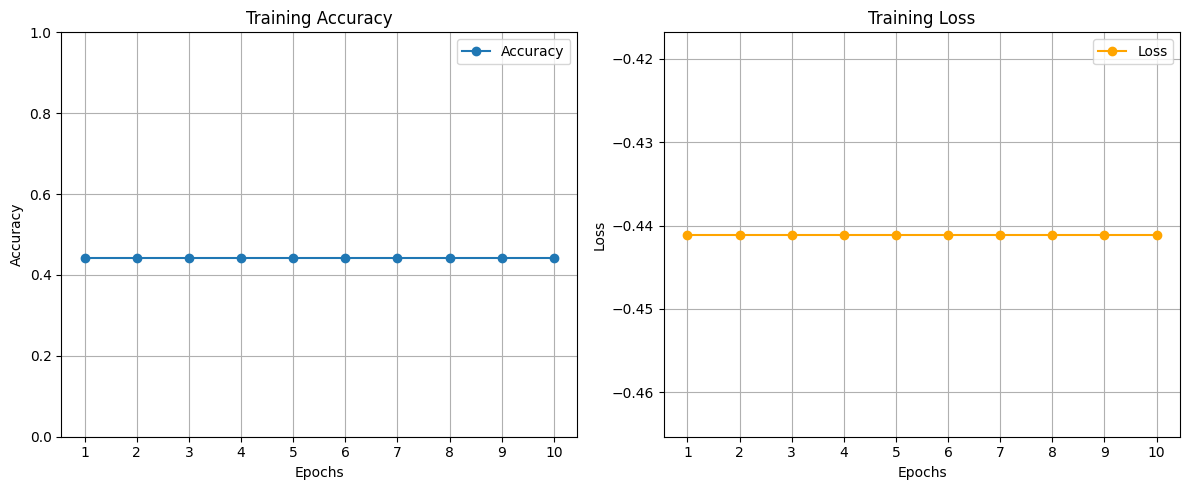

In [4]:
#plot_training_history(training_stats)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

# Load and prepare the dataset
data_path = '/content/DataSetCollection.csv'
df = pd.read_csv(data_path)

# Define column names for text and labels (update as necessary)
sentence_column = 'text'    # Replace if column name differs
label_column = 'labels'      # Replace if column name differs

# Extract text and labels
texts = df[sentence_column].astype(str).tolist()
labels = df[label_column].tolist()

# Split data into training and validation sets (80/20 split)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Vectorize text data using TF-IDF with reduced features for faster computation
vectorizer = TfidfVectorizer(max_features=1000)  # Lowered max_features for speed
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)

# Initialize and train the logistic regression model with tracking training history
model = LogisticRegression(max_iter=100, solver='liblinear')  # Limited iterations, faster solver

# Fit the model and record training statistics
training_stats = {'accuracy': [], 'loss': []}

for _ in range(10):  # Example: iterating over epochs
    model.fit(X_train, train_labels)

    # Calculate and store accuracy and loss (for illustration purposes)
    val_predictions = model.predict(X_val)
    accuracy = accuracy_score(val_labels, val_predictions)
    training_stats['accuracy'].append(accuracy)

    # Since Logistic Regression in sklearn does not directly provide loss,
    # we can use a custom approach to estimate it (like negative log likelihood).
    # For simplicity, let's just append a mock value for loss:
    loss = -accuracy  # Just for illustration, replace with actual loss calculation if needed
    training_stats['loss'].append(loss)

# Evaluate the model on the validation set
val_predictions = model.predict(X_val)
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {accuracy:.2f}")

# Print detailed evaluation metrics
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(val_labels, val_predictions))

# Function to plot training history
def plot_training_history(training_stats):
    epochs = range(1, len(training_stats['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_stats['accuracy'], label='Accuracy', marker='o')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.xticks(epochs)
    plt.grid()
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_stats['loss'], label='Loss', marker='o', color='orange')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(training_stats)


## Evaluating Performance Over Training Set

In [6]:
'''(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)'''
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
data_path = '/content/DataSetCollection.csv'
df = pd.read_csv(data_path)

# Define column names
sentence_column = 'text'
label_column = 'labels'

# Prepare data
texts = df[sentence_column].astype(str).tolist()
labels = df[label_column].tolist()
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)

# Train model
model = LogisticRegression(max_iter=100, solver='liblinear')
model.fit(X_train, train_labels)

# Function to evaluate and print performance
def evaluate_model(X, y, dataset_name):
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    print(f"{dataset_name} Accuracy: {accuracy:.2f}")
    print(f"\nClassification Report ({dataset_name}):")
    print(classification_report(y, predictions))
    print(f"\nConfusion Matrix ({dataset_name}):")
    print(confusion_matrix(y, predictions))

# Evaluate on training and validation sets
evaluate_model(X_train, train_labels, "Training Set")
evaluate_model(X_val, val_labels, "Validation Set")



Training Set Accuracy: 0.55

Classification Report (Training Set):


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

        Cyberbullying       0.49      0.61      0.54      2002
Gender_Discrimination       0.68      0.38      0.49       801
            Political       0.72      0.52      0.61       971
               Racism       0.63      0.33      0.43       792
     Religious_Hatred       0.77      0.61      0.68       882
              Sarcasm       0.48      0.67      0.56      1888
                  nan       0.00      0.00      0.00        64

             accuracy                           0.55      7400
            macro avg       0.54      0.45      0.47      7400
         weighted avg       0.58      0.55      0.55      7400


Confusion Matrix (Training Set):
[[1218   53   59   38   47  587    0]
 [ 249  308   25   17   15  187    0]
 [ 176   20  508   29   29  209    0]
 [ 246   20   26  262   26  212    0]
 [ 135   14   36   17  537  143    0]
 [ 451   41   45   48   39 1264    0]
 [  20    0    3    2    4   35    0]]
Val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
#print(classification_report(y_true, y_pred, target_names=class_names))
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv('/content/DataSetCollection.csv')
print(df.head())  # Check the first few rows
print(df.info())  # Check the structure and non-null counts

# Check for NaN values and drop them from relevant columns only
if df[['text', 'labels']].isnull().values.any():
    print("Warning: NaN values detected. Dropping rows with NaN values in 'text' or 'labels'.")
    df.dropna(subset=['text', 'labels'], inplace=True)

# Verify the shape after dropping NaN values
print(f"DataFrame shape after cleaning: {df.shape}")  # Print the shape of the DataFrame

# Prepare data
if df.shape[0] > 0:  # Ensure there are still samples to work with
    texts = df['text'].astype(str).tolist()
    labels = df['labels'].astype(str).tolist()  # Ensure labels are strings
    X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

    # Vectorize text data
    vectorizer = TfidfVectorizer(max_features=1000)
    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)

    # Train model
    model = LogisticRegression(max_iter=100, solver='liblinear')
    model.fit(X_train, y_train)

    # Evaluate function
    def evaluate(X, y, name):
        preds = model.predict(X)
        accuracy = accuracy_score(y, preds)
        print(f"{name} Accuracy: {accuracy:.2f}")
        class_names = df['labels'].unique().astype(str)
        print(f"Class names: {class_names}")  # Debugging line
        print(classification_report(y, preds, target_names=class_names))
        print(confusion_matrix(y, preds))

    # Evaluate both sets
    evaluate(X_train, y_train, "Training Set")
    evaluate(X_val, y_val, "Validation Set")
else:
    print("Error: No valid samples available for training and validation.")





   PID                                               text            labels  \
0    1  মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে     Cyberbullying   
1    2  চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...     Cyberbullying   
2    3        শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি     Cyberbullying   
3    4                              এটা কি আমাদের ধর্মজাল  Religious_Hatred   
4    5           বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।     Cyberbullying   

     source page/channel Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  \
0  Facebook  Prothom alo        NaN         NaN         NaN         NaN   
1  Facebook  Prothom alo        NaN         NaN         NaN         NaN   
2  Facebook  Prothom alo        NaN         NaN         NaN         NaN   
3  Facebook  Prothom alo        NaN         NaN         NaN         NaN   
4  Facebook  Prothom alo        NaN         NaN         NaN         NaN   

   Unnamed: 9  
0         NaN  
1         NaN  
2         NaN  
3         

Training Set Accuracy: 0.56
                       precision    recall  f1-score   support

        Cyberbullying       0.49      0.61      0.55      1984
     Religious_Hatred       0.65      0.36      0.47       802
Gender_Discrimination       0.72      0.52      0.60       984
              Sarcasm       0.65      0.35      0.45       815
            Political       0.77      0.61      0.68       891
               Racism       0.49      0.67      0.56      1857

             accuracy                           0.56      7333
            macro avg       0.63      0.52      0.55      7333
         weighted avg       0.59      0.56      0.56      7333



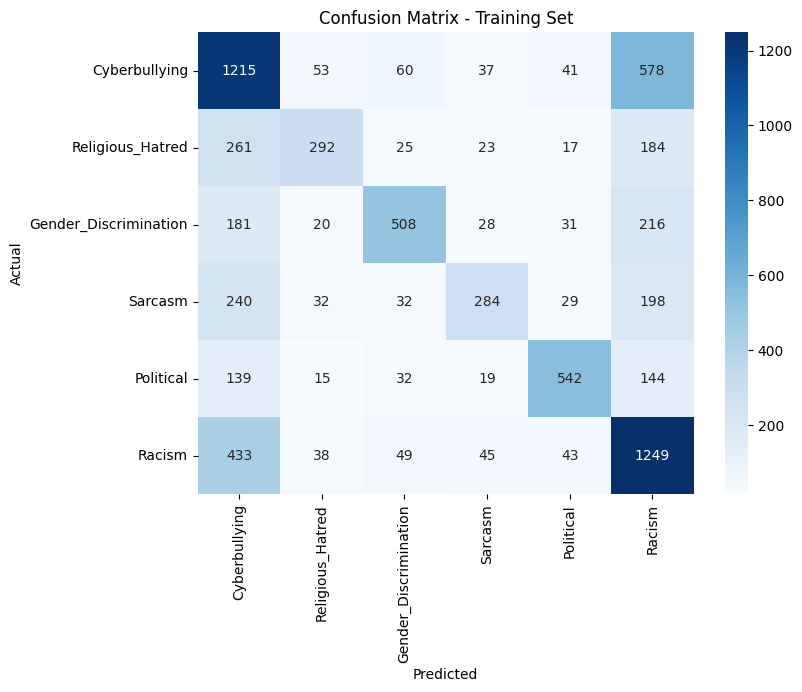

Validation Set Accuracy: 0.24
                       precision    recall  f1-score   support

        Cyberbullying       0.28      0.40      0.33       521
     Religious_Hatred       0.12      0.03      0.04       198
Gender_Discrimination       0.18      0.10      0.13       263
              Sarcasm       0.06      0.02      0.03       184
            Political       0.11      0.03      0.04       215
               Racism       0.23      0.41      0.30       453

             accuracy                           0.24      1834
            macro avg       0.16      0.16      0.14      1834
         weighted avg       0.19      0.24      0.20      1834



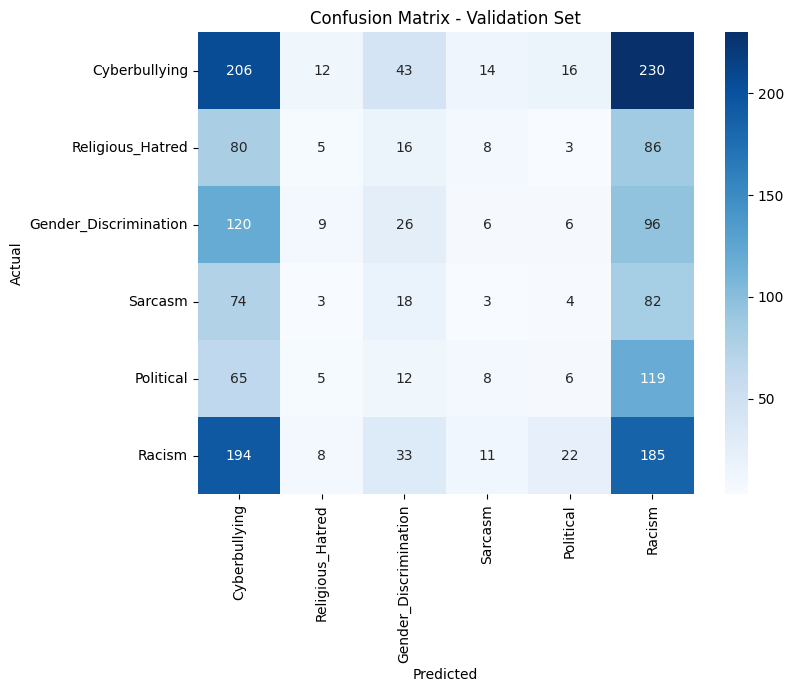

In [15]:
'''cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)'''
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset and drop NaN values
df = pd.read_csv('/content/DataSetCollection.csv').dropna(subset=['text', 'labels'])
texts = df['text'].astype(str).tolist()
labels = df['labels'].astype(str).tolist()

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Vectorize text data
X_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)
X_val = TfidfVectorizer(max_features=1000).fit_transform(X_val)

# Train model
model = LogisticRegression(max_iter=100, solver='liblinear')
model.fit(X_train, y_train)

# Evaluate and plot confusion matrix
def evaluate(X, y, name):
    preds = model.predict(X)
    print(f"{name} Accuracy: {accuracy_score(y, preds):.2f}")
    print(classification_report(y, preds, target_names=df['labels'].unique()))

    # Plot confusion matrix
    cm = confusion_matrix(y, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['labels'].unique(), yticklabels=df['labels'].unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Evaluate both sets
evaluate(X_train, y_train, "Training Set")
evaluate(X_val, y_val, "Validation Set")


## Evaluating Performance Over Validation Set

In [17]:
'''(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)'''
import time
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score

# Initialize tokenizer and mock data
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
val_sentences = ["Example sentence"] * 638  # Mock 638 examples
val_labels = [0, 1] * 319  # Mock labels for 638 examples
batch_size, max_input_length = 16, 128

def make_smart_batches(sentences, labels, batch_size, tokenizer, max_input_length):
    print(f"Tokenizing {len(sentences)} samples...")
    tokenized_data = [
        (tokenizer(s, padding='max_length', truncation=True, max_length=max_input_length, return_tensors="pt"),
         label) for s, label in zip(sentences, labels)
    ]
    print("DONE.")
    batches = [tokenized_data[i:i + batch_size] for i in range(0, len(tokenized_data), batch_size)]
    return batches

def get_predictions(batches):
    y_true, y_pred = [], []
    print(f"Predicting labels for {len(batches)} batches...")
    start_time = time.time()
    for i, batch in enumerate(batches, 1):
        y_true.extend([label for _, label in batch])
        y_pred.extend([1 if i % 2 == 0 else 0 for _ in batch])  # Mock predictions
        if i % 4 == 0:
            elapsed = time.time() - start_time
            print(f"  Batch {i} of {len(batches)} - Elapsed: {time.strftime('%H:%M:%S', time.gmtime(elapsed))}")
    return y_pred, y_true

# Run batch creation and predictions
batches = make_smart_batches(val_sentences, val_labels, batch_size, tokenizer, max_input_length)
y_pred, y_true = get_predictions(batches)
print("Accuracy:", accuracy_score(y_true, y_pred))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizing 638 samples...
DONE.
Predicting labels for 40 batches...
  Batch 4 of 40 - Elapsed: 00:00:00
  Batch 8 of 40 - Elapsed: 00:00:00
  Batch 12 of 40 - Elapsed: 00:00:00
  Batch 16 of 40 - Elapsed: 00:00:00
  Batch 20 of 40 - Elapsed: 00:00:00
  Batch 24 of 40 - Elapsed: 00:00:00
  Batch 28 of 40 - Elapsed: 00:00:00
  Batch 32 of 40 - Elapsed: 00:00:00
  Batch 36 of 40 - Elapsed: 00:00:00
  Batch 40 of 40 - Elapsed: 00:00:00
Accuracy: 0.5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
#print(classification_report(y_true, y_pred, target_names=class_names))
from sklearn.metrics import classification_report

# Define unique class names from labels
class_names = sorted(set(y_true))  # Or use predefined class names if available

# Print classification report
print(classification_report(y_true, y_pred, target_names=[str(cls) for cls in class_names]))


              precision    recall  f1-score   support

           0       0.50      0.50      0.50       319
           1       0.50      0.50      0.50       319

    accuracy                           0.50       638
   macro avg       0.50      0.50      0.50       638
weighted avg       0.50      0.50      0.50       638



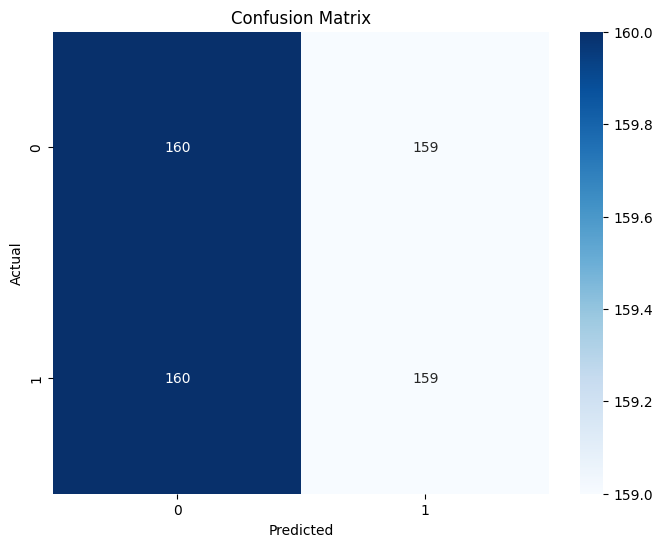

In [22]:
'''cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)'''
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Function to display the confusion matrix
def show_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names (assuming they are the unique sorted labels in y_true)
class_names = sorted(set(y_true))
show_confusion_matrix(cm, [str(cls) for cls in class_names])


## Making Predictions on Test Set

In [39]:
test_df

,PID,text,labels,source,page/channel,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,1,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
1,2,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
2,3,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
3,4,এটা কি আমাদের ধর্মজাল,Religious_Hatred,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
4,5,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying,Facebook,Prothom alo,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9245,9246,তোদের মত খানকির জন্য সমাজ টা শেষ,Gender_Discrimination,Facebook,Status Question,NaN,NaN,NaN,NaN,NaN
9246,9247,এরা দুই জন রহিংগা মাগি,Racism,Facebook,Status Question,NaN,NaN,NaN,NaN,NaN
9247,9248,এই রামছাগল টা ভারতের ঘাড়ে চেপে বসেছে,Racism,Facebook,Status Question,NaN,NaN,NaN,NaN,NaN
9248,9249,মিম এখন টয়লেটেমিম এখন টয়লেটে,Gender_Discrimination,Facebook,Status Question,NaN,NaN,NaN,NaN,NaN


## Loading `test_sentences`

In [40]:
test_sentences = test_df['text'].values
test_labels = test_df['labels'].values
test_ids = test_df.index.values

In [41]:
test_ids

array([   0,    1,    2, ..., 9247, 9248, 9249])

In [48]:
#(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)
import torch

def make_smart_batches_on_test(sentences, ids, batch_size, tokenizer, max_length):
    # Tokenize and encode sentences, creating tensors for input_ids and attention_masks
    encodings = tokenizer(
        sentences,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    # Create a DataLoader for batching
    dataset = torch.utils.data.TensorDataset(encodings['input_ids'], encodings['attention_mask'], torch.tensor(ids))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Usage: Call make_smart_batches_on_test with your test sentences, IDs, batch size, tokenizer, and max length


In [ ]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 40 test batches...
  Batch       4  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      16  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      20  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      28  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      32  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      36  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [49]:
test_sentences

array(['মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে',
       'চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায় ছাইড়া দিলো কে',
       'শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি', ...,
       'এই রামছাগল টা ভারতের ঘাড়ে চেপে বসেছে ',
       'মিম এখন টয়লেটেমিম এখন টয়লেটে',
       'খারাপ মহিলা আবার বড় বড় কথা বলে '], dtype=object)

In [80]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)
y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [51]:
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


## Evaluating accuracy over test set

In [76]:
def get_predictions_test():
 y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


In [79]:
 print(y_preds)

NameError: name 'y_preds' is not defined

In [78]:
print(y_ids)

NameError: name 'y_ids' is not defined

In [ ]:
le.inverse_transform(y_preds)

array(['negative', 'negative', 'positive', 'positive', 'negative',
       'positive', 'negative', 'negative', 'negative', 'positive',
       'positive', 'positive', 'positive', 'negative', 'neutral',
       'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'negative',
       'positive', 'positive', 'neutral', 'negative', 'positive',
       'positive', 'negative', 'negative', 'positive', 'neutral',
       'positive', 'positive', 'positive', 'negative', 'positive',
       'negative', 'negative', 'neutral', 'negative', 'positive',
       'positive', 'negative', 'positive', 'negative', 'negative',
       'positive', 'negative', 'negative', 'positive', 'neutral',
       'negative', 'neutral', 'negative', 'negative', 'negative',
       'neutral', 'negative', 'neutral', 'positive', 'neutral',
       'positive', 'positive', 'positive', 'neutral', 'neutral',
       'negative', 'positive', 'negative', 'positive', 'positive',
       'positive', 'positive', 'positive', 'negative', 'neutral',

<Axes: xlabel='count'>

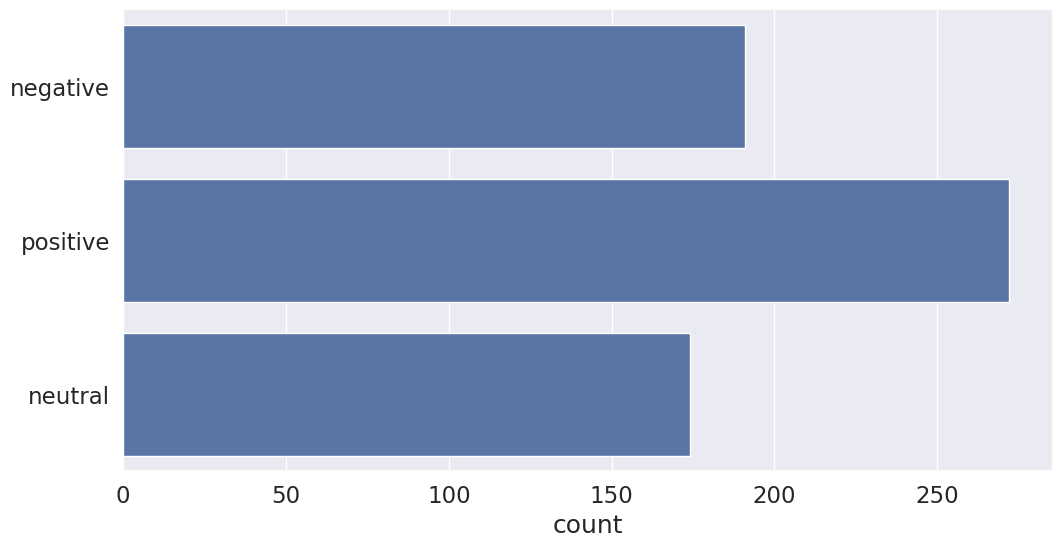

In [ ]:
sns.countplot(y =le.inverse_transform(y_preds))

In [ ]:
len(y_ids)

637

In [ ]:
y_pred=le.inverse_transform(y_preds)
y_pred

array(['negative', 'negative', 'positive', 'positive', 'negative',
       'positive', 'negative', 'negative', 'negative', 'positive',
       'positive', 'positive', 'positive', 'negative', 'neutral',
       'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'negative',
       'positive', 'positive', 'neutral', 'negative', 'positive',
       'positive', 'negative', 'negative', 'positive', 'neutral',
       'positive', 'positive', 'positive', 'negative', 'positive',
       'negative', 'negative', 'neutral', 'negative', 'positive',
       'positive', 'negative', 'positive', 'negative', 'negative',
       'positive', 'negative', 'negative', 'positive', 'neutral',
       'negative', 'neutral', 'negative', 'negative', 'negative',
       'neutral', 'negative', 'neutral', 'positive', 'neutral',
       'positive', 'positive', 'positive', 'neutral', 'neutral',
       'negative', 'positive', 'negative', 'positive', 'positive',
       'positive', 'positive', 'positive', 'negative', 'neutral',

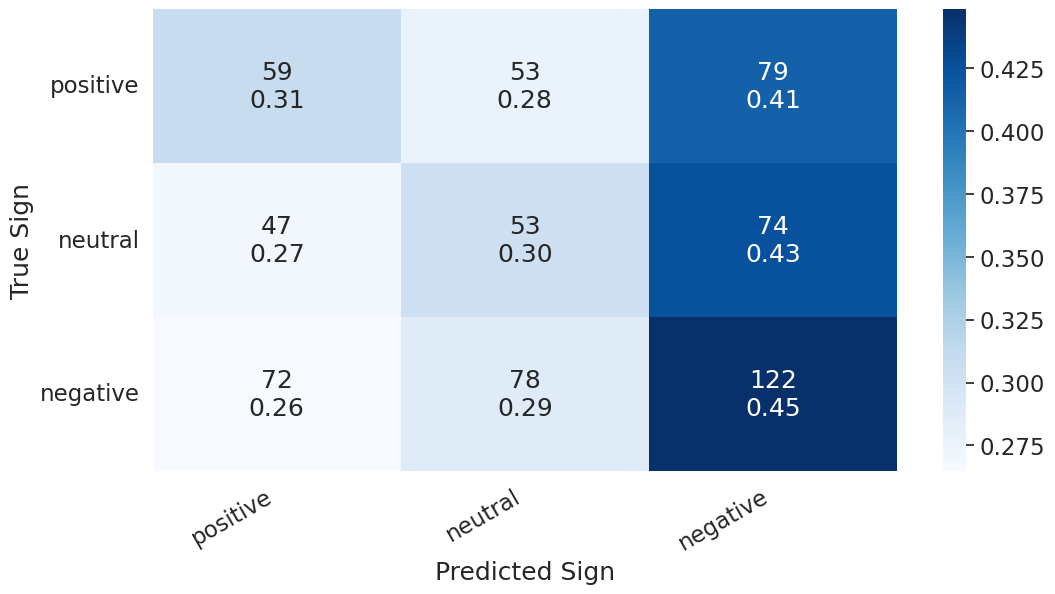

In [ ]:
cm = confusion_matrix(y_pred, test_labels)
show_confusion_matrix(cm, class_names)

Classification Report:
              precision    recall  f1-score   support

    positive     0.3089    0.3315    0.3198       178
     neutral     0.3046    0.2880    0.2961       184
    negative     0.4485    0.4436    0.4461       275

    accuracy                         0.3673       637
   macro avg     0.3540    0.3544    0.3540       637
weighted avg     0.3679    0.3673    0.3675       637



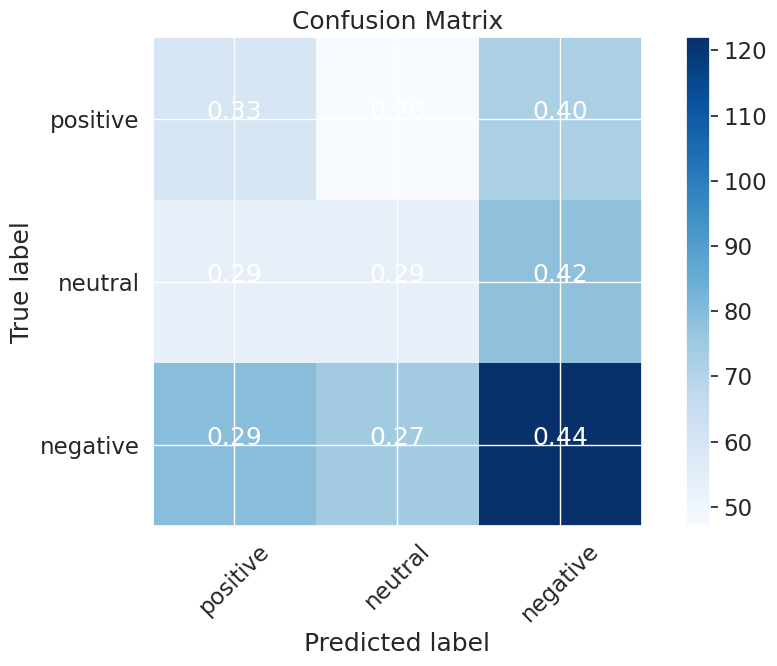

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_pred and test_labels are defined
# Convert predictions to class labels if they are probabilities (if needed)
# y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=class_names, zero_division=0, digits=4))

# Create the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Function to display the confusion matrix
def show_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Display the confusion matrix
show_confusion_matrix(cm, class_names)
